In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv("influencers_data.csv", index_col=0)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
print(data.head())

             name        headline location followers connections  \
0  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
1  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
2  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
3  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
4  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   

                                               about    time_spent  \
0  Nicholas Wyman for the past 25 years has shone...     1 day ago   
1  Nicholas Wyman for the past 25 years has shone...    1 week ago   
2  Nicholas Wyman for the past 25 years has shone...  2 months ago   
3  Nicholas Wyman for the past 25 years has shone...  2 months ago   
4  Nicholas Wyman for the past 25 years has shone...  2 months ago   

                                             content  \
0  Robert Lerman  writes that achieving a healthy...   
1  National disability advocate  Sara Hart Weir, ...   
2 

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\1488050072.py:1: DtypeWarning: Columns (0,4,12,13,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,89,90,91,92,93,94,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,114,115,117,118,119,120,121,122,124,125,126,127,128,129,131,132,133,134,135,136,138,139,140,141,142,143,145,146,147,148,149,150,152,153,154,155,156,157,159,160,161,162,163,164,167) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("influencers_data.csv", index_col=0)


##### EDA

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34520 entries, 0 to 34011
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               33914 non-null  object
 1   headline           33874 non-null  object
 2   location           31644 non-null  object
 3   followers          33872 non-null  object
 4   connections        25637 non-null  object
 5   about              33914 non-null  object
 6   time_spent         33864 non-null  object
 7   content            31993 non-null  object
 8   content_links      33393 non-null  object
 9   media_type         26828 non-null  object
 10  media_url          33410 non-null  object
 11  num_hashtags       33393 non-null  object
 12  hashtag_followers  33391 non-null  object
 13  hashtags           33240 non-null  object
 14  reactions          33344 non-null  object
 15  comments           33192 non-null  object
 16  views              1198 non-null   object
 17

In [4]:
columns_to_check = ["followers", "reactions", "comments"]
data = data.drop(columns=[col for col in columns_to_check if data[col].isnull().all()])
print(data.head())

             name        headline location followers connections  \
0  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
1  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
2  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
3  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
4  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   

                                               about    time_spent  \
0  Nicholas Wyman for the past 25 years has shone...     1 day ago   
1  Nicholas Wyman for the past 25 years has shone...    1 week ago   
2  Nicholas Wyman for the past 25 years has shone...  2 months ago   
3  Nicholas Wyman for the past 25 years has shone...  2 months ago   
4  Nicholas Wyman for the past 25 years has shone...  2 months ago   

                                             content  \
0  Robert Lerman  writes that achieving a healthy...   
1  National disability advocate  Sara Hart Weir, ...   
2 

##### Key Metrics for Scoring

In [5]:
data['time_spent'].unique()

array(['1 day ago', '1 week ago', '2 months ago', '3 months ago',
       '4 months ago', '5 months ago', '6 months ago', '7 months ago',
       '8 months ago', '9 months ago', '10 months ago', '11 months ago',
       '1 year ago', '2 years ago', '3 years ago', '4 years ago',
       '5 years ago', '6 years ago', '3 days ago', '2 weeks ago',
       '3 weeks ago', '1 month ago', '4 days ago', nan, '32',
       '7 years ago', '1 hour ago', '3 hours ago', '5 hours ago',
       '2 days ago', '6 days ago', '15 hours ago', '19 hours ago',
       '20 hours ago', '[]', '7 hours ago', '8 hours ago', '22 hours ago',
       '5 days ago', '4 hours ago', '14 hours ago', '2 hours ago',
       '6 hours ago', '10 hours ago', '13 hours ago',
       ' his term for a global power vacuum in which no country is willing and able to set the international agenda',
       '18 hours ago', '21 hours ago', '23 hours ago', '9 hours ago',
       '350', ' the shows you watch', '220', " '#marketing']",
       ' \'#resi

#1. Post Frequency

In [6]:
def convert_time_to_days(time_str):
    try:
        if pd.isna(time_str):  # Return NaN if the value is missing
            return np.nan
        elif "hour" in time_str:
            return int(time_str.split()[0]) / 24  # Convert hours to days
        elif "day" in time_str:
            return int(time_str.split()[0])  # Extract the number of days
        elif "week" in time_str:
            return int(time_str.split()[0]) * 7  # Convert weeks to days
        elif "month" in time_str:
            return int(time_str.split()[0]) * 30  # Convert months to days
        elif "year" in time_str:
            return int(time_str.split()[0]) * 365  # Convert years to days
        else:
            return np.nan  # Return NaN for non-time-related data
    except (ValueError, AttributeError):  # Handle cases with invalid or unparsable input
        return np.nan

# Convert the "time_spent" column to days
data["days_since_post"] = data["time_spent"].apply(convert_time_to_days)

# Remove rows where "days_since_post" is NaN
data_cleaned = data.dropna(subset=["days_since_post"])

# Display the first 20 rows of the cleaned data
print(data_cleaned[["time_spent", "days_since_post"]].head(20))

       time_spent  days_since_post
0       1 day ago              1.0
1      1 week ago              7.0
2    2 months ago             60.0
3    2 months ago             60.0
4    2 months ago             60.0
5    2 months ago             60.0
6    2 months ago             60.0
7    3 months ago             90.0
8    3 months ago             90.0
9    4 months ago            120.0
10   4 months ago            120.0
11   5 months ago            150.0
12   6 months ago            180.0
13   7 months ago            210.0
14   8 months ago            240.0
15   8 months ago            240.0
16   9 months ago            270.0
17   9 months ago            270.0
18   9 months ago            270.0
19  10 months ago            300.0


In [7]:
# Group by "name" and "headline" to calculate required statistics
grouped = data_cleaned.groupby(["name", "headline"]).agg(
    total_posts=("days_since_post", "count"),    # Total number of posts
    min_days=("days_since_post", "min"),         # Earliest post (in days)
    max_days=("days_since_post", "max")          # Most recent post (in days)
).reset_index()

# Calculate the time range (max_days - min_days)
grouped["time_range"] = grouped["max_days"] - grouped["min_days"]

# Identify users with only one post
grouped["single_post"] = grouped["total_posts"] == 1

# Handle cases where time_range is zero
grouped["time_range"] = grouped["time_range"].replace(0, np.nan)

# Calculate post frequency (total posts / time range)
grouped["post_frequency"] = grouped["total_posts"] / grouped["time_range"]

# For single posts, set post_frequency to NaN (or 0 if desired)
grouped.loc[grouped["single_post"], "post_frequency"] = 0 
# Display the resulting grouped data
print(grouped)

                   name                                           headline  \
0     ?? Pascal Bouvier  Managing Partner & Co-Founder, MiddleGame Vent...   
1             AJ Wilcox  LinkedIn Ads Fanatic and Host of The LinkedIn ...   
2          Amy Blaschka  Social Media Ghostwriter (Yep, that? a thing....   
3           Andrew Yang  Candidate for NYC Mayor in 2021 (D) at Yangfor...   
4    Barry W. Enderwick                           Marketing/Brand/Business   
..                  ...                                                ...   
62         Tom Foremski  Former Financial Times journalist?ditor of Si...   
63          Tom Goodwin                   Co-Founder of ALL WE HAVE IS NOW   
64            Vani Kola                       Managing Director at Kalaari   
65  Vikram Mansharamani  Author, Academic, Advisor; Worth Power 100; Li...   
66          Yasi Baiani  Head of Product, Mental Health at Teladoc | Ha...   

    total_posts    min_days  max_days   time_range  single_post

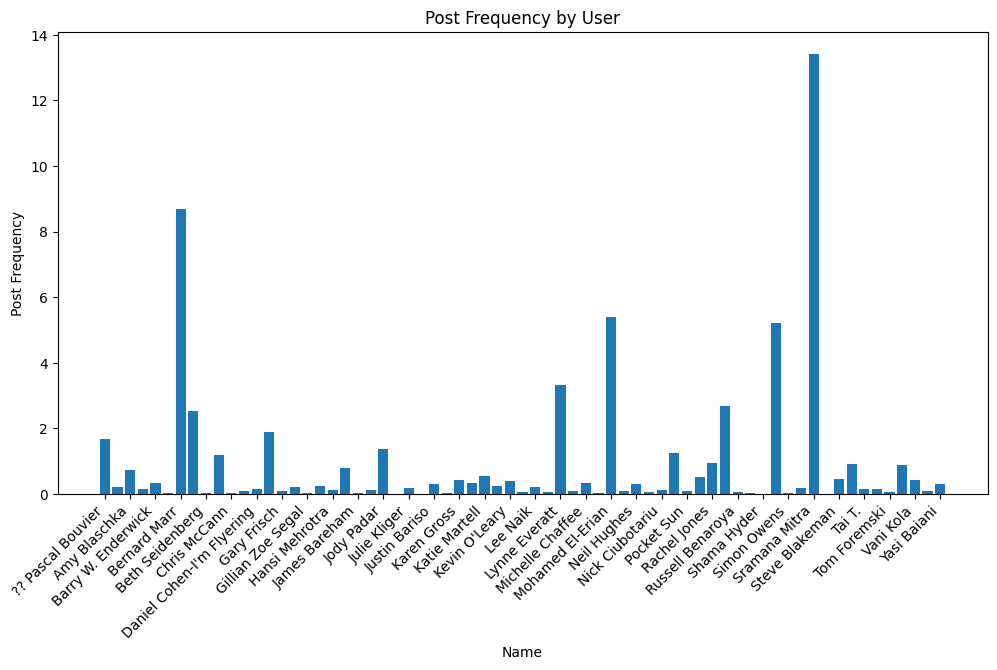

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(grouped["name"], grouped["post_frequency"])
plt.xlabel("Name")
plt.ylabel("Post Frequency")
plt.title("Post Frequency by User")
plt.xticks(ticks=range(0, len(grouped["name"]), 2), labels=grouped["name"][::2], rotation=45, ha="right")
plt.show()

#2. Engagement Rate-reaction/followers

In [9]:
# Convert "reactions" and "followers" columns to numeric type
data_cleaned["reactions"] = pd.to_numeric(data_cleaned["reactions"], errors="coerce")
data_cleaned["followers"] = pd.to_numeric(data_cleaned["followers"], errors="coerce")

# Replace NaN values in "reactions" with 0
data_cleaned["reactions"] = data_cleaned["reactions"].fillna(0)

# Replace 0 values in "followers" with NaN, then fill NaN with 1 (to prevent division by zero)
data_cleaned["followers"] = data_cleaned["followers"].replace(0, np.nan).fillna(1)

# Calculate the reaction ratio for each record
data_cleaned["reaction_ratio"] = data_cleaned["reactions"] / np.log1p(data_cleaned["followers"])

# Group by "name" and "headline" to calculate the average reaction ratio
reaction_summary = data_cleaned.groupby(["name", "headline"]).agg(
    avg_reaction_ratio=("reaction_ratio", "mean")  # Average reaction ratio
).reset_index()

# Display the grouped summary
print(reaction_summary)

                   name                                           headline  \
0     ?? Pascal Bouvier  Managing Partner & Co-Founder, MiddleGame Vent...   
1             AJ Wilcox  LinkedIn Ads Fanatic and Host of The LinkedIn ...   
2          Amy Blaschka  Social Media Ghostwriter (Yep, that? a thing....   
3           Andrew Yang  Candidate for NYC Mayor in 2021 (D) at Yangfor...   
4    Barry W. Enderwick                           Marketing/Brand/Business   
..                  ...                                                ...   
62         Tom Foremski  Former Financial Times journalist?ditor of Si...   
63          Tom Goodwin                   Co-Founder of ALL WE HAVE IS NOW   
64            Vani Kola                       Managing Director at Kalaari   
65  Vikram Mansharamani  Author, Academic, Advisor; Worth Power 100; Li...   
66          Yasi Baiani  Head of Product, Mental Health at Teladoc | Ha...   

    avg_reaction_ratio  
0             0.797320  
1            

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3715876191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["reactions"] = pd.to_numeric(data_cleaned["reactions"], errors="coerce")
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3715876191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["followers"] = pd.to_numeric(data_cleaned["followers"], errors="coerce")
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3715876191.py:6: SettingWithCopyWarning: 
A value is trying to b

#3. Engagement Rate-comment/followers

In [10]:
# Convert "comments" and "followers" columns to numeric type
data_cleaned["comments"] = pd.to_numeric(data_cleaned["comments"], errors="coerce")
data_cleaned["followers"] = pd.to_numeric(data_cleaned["followers"], errors="coerce")

# Replace NaN values in "comments" with 0
data_cleaned["comments"] = data_cleaned["comments"].fillna(0)

# Replace 0 values in "followers" with NaN, then fill NaN with 1 (to prevent division by zero)
data_cleaned["followers"] = data_cleaned["followers"].replace(0, np.nan).fillna(1)

# Calculate the comment ratio for each record
data_cleaned["comment_ratio"] = data_cleaned["comments"] / np.log1p(data_cleaned["followers"])

# Group by "name" and "headline" to calculate the average comment ratio
comment_summary = data_cleaned.groupby(["name", "headline"]).agg(
    avg_comment_ratio=("comment_ratio", "mean")  # Average comment ratio
).reset_index()

# Display the grouped summary
print(comment_summary)

                   name                                           headline  \
0     ?? Pascal Bouvier  Managing Partner & Co-Founder, MiddleGame Vent...   
1             AJ Wilcox  LinkedIn Ads Fanatic and Host of The LinkedIn ...   
2          Amy Blaschka  Social Media Ghostwriter (Yep, that? a thing....   
3           Andrew Yang  Candidate for NYC Mayor in 2021 (D) at Yangfor...   
4    Barry W. Enderwick                           Marketing/Brand/Business   
..                  ...                                                ...   
62         Tom Foremski  Former Financial Times journalist?ditor of Si...   
63          Tom Goodwin                   Co-Founder of ALL WE HAVE IS NOW   
64            Vani Kola                       Managing Director at Kalaari   
65  Vikram Mansharamani  Author, Academic, Advisor; Worth Power 100; Li...   
66          Yasi Baiani  Head of Product, Mental Health at Teladoc | Ha...   

    avg_comment_ratio  
0            0.121329  
1            1.

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\2780109231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["comments"] = pd.to_numeric(data_cleaned["comments"], errors="coerce")
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\2780109231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["followers"] = pd.to_numeric(data_cleaned["followers"], errors="coerce")
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\2780109231.py:6: SettingWithCopyWarning: 
A value is trying to be 

##### Merge dataframes

In [11]:
merged_df = pd.merge(grouped, reaction_summary, on=["name", "headline"])
merged_df = pd.merge(merged_df, comment_summary, on=["name", "headline"])
selected_columns = ["name", "post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]
final_df = merged_df[selected_columns]
print(final_df)

                   name  post_frequency  avg_reaction_ratio  avg_comment_ratio
0     ?? Pascal Bouvier        1.685775            0.797320           0.121329
1             AJ Wilcox        0.204764            5.667536           1.854607
2          Amy Blaschka        0.740741           15.223396           6.051570
3           Andrew Yang        0.136438            3.891861           0.335315
4    Barry W. Enderwick        0.318026            1.430851           0.278506
..                  ...             ...                 ...                ...
62         Tom Foremski        0.052333            0.514636           0.093027
63          Tom Goodwin        0.869327           27.736618           4.940680
64            Vani Kola        0.432951           83.327726           3.255593
65  Vikram Mansharamani        0.101927            1.669468           0.180445
66          Yasi Baiani        0.302857            8.379183           0.416743

[67 rows x 4 columns]


##### Generate a 3D scatter plot 
In this analysis, user behavior is quantitatively represented using three key indicators: post frequency, average reaction ratio, and average comment ratio. These metrics are designed to capture different aspects of user activity and engagement:

Post Frequency: Reflects how often a user posts content within a specified timeframe, indicating their activity level.
Average Reaction Ratio: Represents the average number of reactions (e.g., likes) a user receives per follower, measuring audience engagement with their posts.
Average Comment Ratio: Captures the average number of comments a user receives per follower, reflecting the depth of interaction their content generates.

In [12]:
# Columns to be standardized
final_df["avg_reaction_ratio"] = np.log1p(final_df["avg_reaction_ratio"] - final_df["avg_reaction_ratio"].min() + 1)
final_df["avg_comment_ratio"] = np.log1p(final_df["avg_comment_ratio"] - final_df["avg_comment_ratio"].min() + 1)

columns_to_scale = ["post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]
scaler = StandardScaler()
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])
print(final_df)

                   name  post_frequency  avg_reaction_ratio  avg_comment_ratio
0     ?? Pascal Bouvier        0.367737           -0.839535          -0.554199
1             AJ Wilcox       -0.334690           -0.036935           0.170110
2          Amy Blaschka       -0.080483            0.607220           1.063447
3           Andrew Yang       -0.367097           -0.246611          -0.437645
4    Barry W. Enderwick       -0.280972           -0.677041          -0.467512
..                  ...             ...                 ...                ...
62         Tom Foremski       -0.406987           -0.924332          -0.570488
63          Tom Goodwin       -0.019495            1.041906           0.883387
64            Vani Kola       -0.226464            1.880951           0.546103
65  Vikram Mansharamani       -0.383465           -0.623522          -0.520864
66          Yasi Baiani       -0.288166            0.204089          -0.396078

[67 rows x 4 columns]


C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\4173288431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["avg_reaction_ratio"] = np.log1p(final_df["avg_reaction_ratio"] - final_df["avg_reaction_ratio"].min() + 1)
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\4173288431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["avg_comment_ratio"] = np.log1p(final_df["avg_comment_ratio"] - final_df["avg_comment_ratio"].min() + 1)
C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\41732

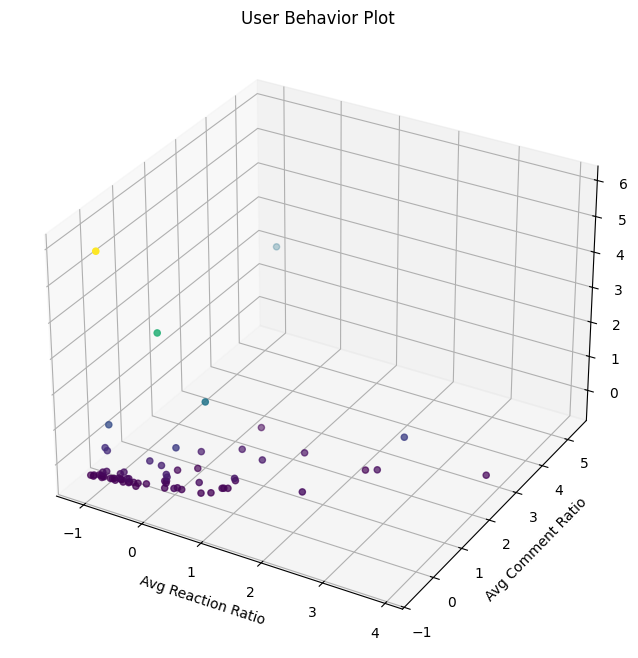

In [13]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data
x = final_df["avg_reaction_ratio"]
y = final_df["avg_comment_ratio"]
z = final_df["post_frequency"]

# Plot the 3D scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Add labels and title
ax.set_xlabel("Avg Reaction Ratio")
ax.set_ylabel("Avg Comment Ratio")
ax.set_zlabel("Post Frequency")
ax.set_title("User Behavior Plot")

# Display the plot
plt.show()

##### K-Means clustering
Users can be grouped based on their three behavioral features (post_frequency, avg_reaction_ratio, avg_comment_ratio) to cluster users with similar scores.

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3407540056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[["post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]] = final_df[


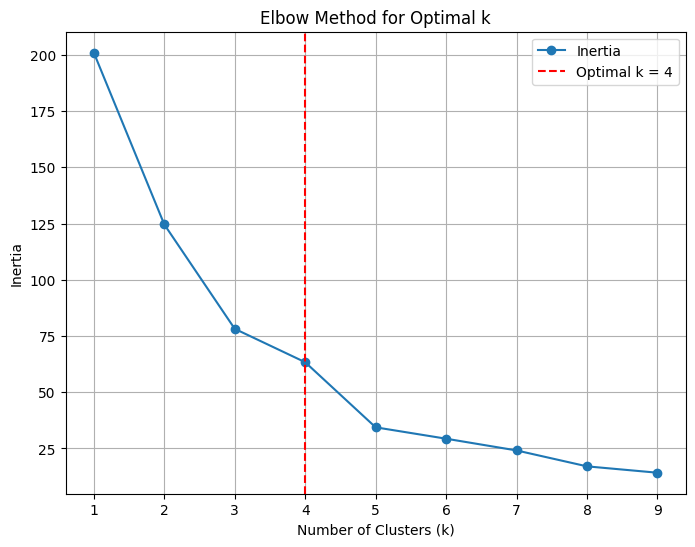

Optimal number of clusters: 4
                   name  post_frequency  avg_reaction_ratio  \
0     ?? Pascal Bouvier        0.367737           -0.839535   
1             AJ Wilcox       -0.334690           -0.036935   
2          Amy Blaschka       -0.080483            0.607220   
3           Andrew Yang       -0.367097           -0.246611   
4    Barry W. Enderwick       -0.280972           -0.677041   
..                  ...             ...                 ...   
62         Tom Foremski       -0.406987           -0.924332   
63          Tom Goodwin       -0.019495            1.041906   
64            Vani Kola       -0.226464            1.880951   
65  Vikram Mansharamani       -0.383465           -0.623522   
66          Yasi Baiani       -0.288166            0.204089   

    avg_comment_ratio  cluster  
0           -0.554199        0  
1            0.170110        0  
2            1.063447        3  
3           -0.437645        0  
4           -0.467512        0  
..             

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3407540056.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["cluster"] = kmeans.fit_predict(data_to_cluster)


In [14]:
# Ensure columns are numeric; set invalid conversions to NaN
final_df[["post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]] = final_df[
    ["post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]
].apply(pd.to_numeric, errors="coerce")

# Extract features for clustering and drop rows with missing values
data_to_cluster = final_df[["post_frequency", "avg_reaction_ratio", "avg_comment_ratio"]].dropna()

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 10)  # Test cluster numbers from 1 to 9
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_to_cluster)
    inertia.append(kmeans.inertia_)

# Automatically calculate the elbow point using the second derivative
second_derivative = np.diff(inertia, 2)  # Compute the second-order difference
optimal_k = k_values[np.argmin(second_derivative) + 1]  # Get the k value corresponding to the elbow point

# Plot the Elbow Method curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o", label="Inertia")
plt.axvline(optimal_k, color="red", linestyle="--", label=f"Optimal k = {optimal_k}")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid()
plt.show()

# Perform KMeans clustering with the automatically selected number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_df["cluster"] = kmeans.fit_predict(data_to_cluster)

# Display the results
print(f"Optimal number of clusters: {optimal_k}")
print(final_df[["name", "post_frequency", "avg_reaction_ratio", "avg_comment_ratio", "cluster"]])

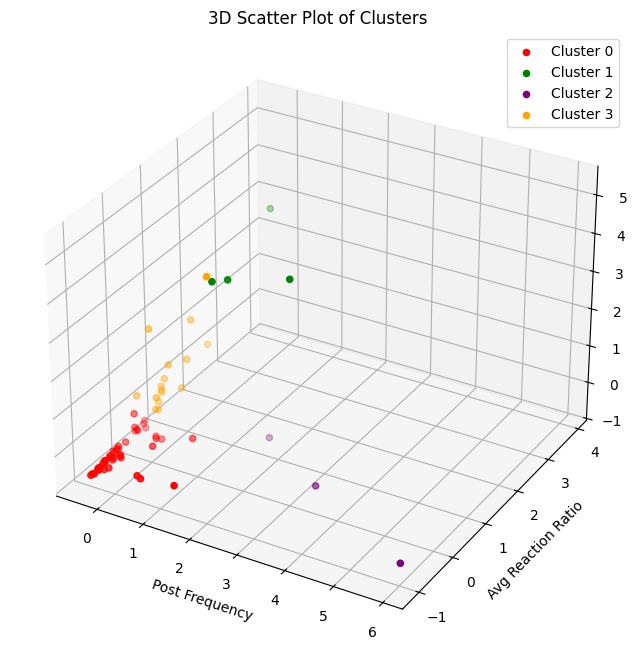

In [15]:
# Define a list of colors and cluster labels for the legend
cluster_colors = ['red', 'green', 'purple', 'orange']  # Adjust based on the number of clusters
cluster_labels = sorted(final_df["cluster"].unique())  # Get unique cluster labels
color_mapping = dict(zip(cluster_labels, cluster_colors))

# Map cluster labels to colors
colors = [color_mapping[label] for label in final_df["cluster"]]

# Extract features for plotting
x = final_df["post_frequency"]
y = final_df["avg_reaction_ratio"]
z = final_df["avg_comment_ratio"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with cluster-specific colors
for label, color in color_mapping.items():
    cluster_data = final_df[final_df["cluster"] == label]
    ax.scatter(
        cluster_data["post_frequency"],
        cluster_data["avg_reaction_ratio"],
        cluster_data["avg_comment_ratio"],
        color=color,
        marker='o',
        label=f"Cluster {label}"
    )

# Add labels and title
ax.set_xlabel("Post Frequency")
ax.set_ylabel("Avg Reaction Ratio")
ax.set_zlabel("Avg Comment Ratio")
ax.set_title("3D Scatter Plot of Clusters")

# Add legend to indicate color-cluster mapping
ax.legend(loc="upper right")

# Display the plot
plt.show()

##### mapping回原dataframe，找出post content；跟example ads 做consine similarity找最接近關鍵字

In [16]:
def merge_columns(series):
    return '; '.join(series.dropna().unique())

merged_df = data_cleaned.groupby('name').agg({
    'headline': merge_columns,
    'about': merge_columns,
    'content': merge_columns
}).reset_index()

merged_df

,name,headline,about,content
0,?? Pascal Bouvier,"Managing Partner & Co-Founder, MiddleGame Vent...",i co-founded MiddleGame Ventures (MGV) and inv...,interesting bitcoin musings; the business of v...
1,AJ Wilcox,LinkedIn Ads Fanatic and Host of The LinkedIn ...,?????????? ????? ??? ??? ?? ????...,I am so excited to be a part of this webinar! ...
2,Amy Blaschka,"Social Media Ghostwriter (Yep, that? a thing....","Hey there, curious one!If you?e reading this,...",News flash: What? preventing your career prog...
3,Andrew Yang,Candidate for NYC Mayor in 2021 (D) at Yangfor...,I moved to New York City 25 years ago. I came ...,Our Q1 fundraising numbers. THANK YOU. This ca...
4,Barry W. Enderwick,Marketing/Brand/Business,I? a brand and marketing executive with a 20-...,I got to live a well defined and clearly artic...
...,...,...,...,...
62,Tom Foremski,Former Financial Times journalist?ditor of Si...,??In mid-2004 I became the first journalist to...,https://lnkd.in/gVhs8ZJ; A rarity -- a Silicon...
63,Tom Goodwin,Co-Founder of ALL WE HAVE IS NOW,The best way to find out about me is to ask my...,A lot of companies these days are essentially ...
64,Vani Kola,Managing Director at Kalaari,Vani Kola is the Founder and Managing Director...,Never too old. Couldn't help smiling at this. ...
65,Vikram Mansharamani,"Author, Academic, Advisor; Worth Power 100; Li...",Dr. Vikram Mansharamani is a global trend-watc...,"Had a fabulous conversation with Kevin Warren,..."


In [17]:
merged_df = pd.merge(merged_df, final_df, on='name', how='left')
merged_df

,name,headline,about,content,post_frequency,avg_reaction_ratio,avg_comment_ratio,cluster
0,?? Pascal Bouvier,"Managing Partner & Co-Founder, MiddleGame Vent...",i co-founded MiddleGame Ventures (MGV) and inv...,interesting bitcoin musings; the business of v...,0.367737,-0.839535,-0.554199,0
1,AJ Wilcox,LinkedIn Ads Fanatic and Host of The LinkedIn ...,?????????? ????? ??? ??? ?? ????...,I am so excited to be a part of this webinar! ...,-0.334690,-0.036935,0.170110,0
2,Amy Blaschka,"Social Media Ghostwriter (Yep, that? a thing....","Hey there, curious one!If you?e reading this,...",News flash: What? preventing your career prog...,-0.080483,0.607220,1.063447,3
3,Andrew Yang,Candidate for NYC Mayor in 2021 (D) at Yangfor...,I moved to New York City 25 years ago. I came ...,Our Q1 fundraising numbers. THANK YOU. This ca...,-0.367097,-0.246611,-0.437645,0
4,Barry W. Enderwick,Marketing/Brand/Business,I? a brand and marketing executive with a 20-...,I got to live a well defined and clearly artic...,-0.280972,-0.677041,-0.467512,0
...,...,...,...,...,...,...,...,...
62,Tom Foremski,Former Financial Times journalist?ditor of Si...,??In mid-2004 I became the first journalist to...,https://lnkd.in/gVhs8ZJ; A rarity -- a Silicon...,-0.406987,-0.924332,-0.570488,0
63,Tom Goodwin,Co-Founder of ALL WE HAVE IS NOW,The best way to find out about me is to ask my...,A lot of companies these days are essentially ...,-0.019495,1.041906,0.883387,3
64,Vani Kola,Managing Director at Kalaari,Vani Kola is the Founder and Managing Director...,Never too old. Couldn't help smiling at this. ...,-0.226464,1.880951,0.546103,3
65,Vikram Mansharamani,"Author, Academic, Advisor; Worth Power 100; Li...",Dr. Vikram Mansharamani is a global trend-watc...,"Had a fabulous conversation with Kevin Warren,...",-0.383465,-0.623522,-0.520864,0


##### Example ad: Unicycive Therapeutics

In [18]:
target_ad = """
Big news alert! The FDA has accepted our New Drug Application (NDA) and has set a PDUFA date of June 28, 2025 
for making an approval decision on our lead asset, Oxylanthanum Carbonate (OLC). If approved, OLC will provide 
patients with chronic kidney disease on dialysis a hyperphosphatemia treatment with a potential best-in-class 
profile that could offer meaningful patient adherence benefits due to lower pill burden in terms of number and 
size of pills per dose that are swallowed instead of chewed. We are thrilled to be one step closer to potentially 
delivering a much needed next-gen solution to many patients.
"""

In [19]:
df = merged_df.copy()

In [20]:
# Set SpaCy's maximum text length to handle long inputs
# Load SpaCy's small English model
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1500000  # Increase limit to 1.5 million characters

# Define the text preprocessing function
def preprocess_text_spacy(text):
    """
    Perform text preprocessing using SpaCy, including tokenization,
    removing stop words, and punctuation.
    """
    doc = nlp(str(text))  # Parse text using SpaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)  # Return the preprocessed text

# Preprocess text in each column
for column in ['headline', 'about', 'content']:
    df[column] = df[column].apply(preprocess_text_spacy)

# Preprocess the target advertisement text
target_ad = preprocess_text_spacy(target_ad)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Compute similarity for headline, about, and content columns
for column in ['headline', 'about', 'content']:
    # Vectorize the column text
    column_texts = df[column].fillna('').tolist()  # Convert column to a list
    tfidf_matrix = vectorizer.fit_transform(column_texts + [target_ad])  # Add target_ad as a separate vector

    # Compute cosine similarity (compare all rows to target_ad)
    similarity_scores = cosine_similarity(tfidf_matrix[:-1], tfidf_matrix[-1:])  # Exclude the target_ad row itself
    similarity_scores = similarity_scores.flatten()  # Flatten the result to 1D

    # Add similarity scores to the DataFrame
    if len(similarity_scores) == len(df):  # Check if lengths match
        df[f'{column}_similarity'] = similarity_scores
    else:
        raise ValueError(f"Length mismatch: {len(similarity_scores)} vs {len(df)}")

# Display the results
print(df[['name', 'headline_similarity', 'about_similarity', 'content_similarity', 'cluster']])

                   name  headline_similarity  about_similarity  \
0     ?? Pascal Bouvier                  0.0          0.016321   
1             AJ Wilcox                  0.0          0.025909   
2          Amy Blaschka                  0.0          0.013944   
3           Andrew Yang                  0.0          0.006963   
4    Barry W. Enderwick                  0.0          0.011606   
..                  ...                  ...               ...   
62         Tom Foremski                  0.0          0.037253   
63          Tom Goodwin                  0.0          0.044975   
64            Vani Kola                  0.0          0.026182   
65  Vikram Mansharamani                  0.0          0.043363   
66          Yasi Baiani                  0.0          0.010111   

    content_similarity  cluster  
0             0.028651        0  
1             0.021189        0  
2             0.029512        3  
3             0.045010        0  
4             0.025845        0  
.. 

##### 
`Highest Weight: content_similarity`: The relevance between the user's post content and the ad content is the core metric. Therefore, assign a higher weight to content_similarity, such as 0.6–0.8.<br>
`Medium Weight: about_similarity`: The about field describes the user's background and interests, which can influence whether they match the ad's target audience. However, it is secondary to content.<br>
`Lowest Weight: headline_similarity`: The headline is usually a brief title or slogan and may not comprehensively reflect the user's relevance to the ad.

In [21]:
content_weight = 0.6
about_weight = 0.3
headline_weight = 0.1

df['total_similarity'] = (
    df['content_similarity'] * content_weight +
    df['about_similarity'] * about_weight +
    df['headline_similarity'] * headline_weight
)

In [22]:
sorted_df = (
    df.groupby('cluster', group_keys=False)  
    .apply(lambda x: x.sort_values('total_similarity', ascending=False)) 
)
sorted_df

C:\Users\cindy\AppData\Local\Temp\ipykernel_23648\3483043339.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('total_similarity', ascending=False))


,name,headline,about,content,post_frequency,avg_reaction_ratio,avg_comment_ratio,cluster,headline_similarity,about_similarity,content_similarity,total_similarity
24,Julie Kliger,Senior Managing Director FTI Consulting Health...,experienced clinician independent consultant h...,Healthcare workers??parallel pandemic Chronic ...,-0.342614,-0.024122,-0.209739,0,0.0,0.076247,0.124026,0.097290
38,Michelle Chaffee,Founder CEO alska- \n Linkedin voice,Entrepreneur Michelle Chaffee founder CEO alsk...,agree add caregiving include care child age pa...,-0.271664,-0.515335,-0.552021,0,0.0,0.090378,0.043330,0.053111
7,"Bertalan Mesk籀, MD, PhD",Director Medical Futurist Institute Keynote Sp...,Dr. Bertalan Mesko phd Medical Futurist analyz...,collection A.I. study publish week link commen...,0.767627,0.184621,-0.265007,0,0.0,0.009038,0.063721,0.040944
37,Marianne Griebler,give Message Clarity Impact | Marketing Strate...,important actually people understand benefit...,tis season catch people see speak awhile chanc...,-0.384595,-0.646443,-0.514071,0,0.0,0.029304,0.048332,0.037790
36,Lynne Everatt,author 5 Minute Recharge act friendship recove...,meet party i? want talking know learn hope do...,enjoy excellent virtual Google Talk Daniel Lie...,1.136774,-0.794679,-0.557638,0,0.0,0.024514,0.046232,0.035093
...,...,...,...,...,...,...,...,...,...,...,...,...
19,James Altucher,founder James Altucher podcast,James 10 Linkedin Influencer prolific writer s...,tonight Miami Comedy NYC tour continue 5 show ...,-0.060005,0.930960,0.180615,3,0.0,0.000000,0.026077,0.015646
34,Lee Naik,CEO TransUnion Africa | LinkedIn voice,Lee Naik CEO big datum insight drive company T...,It? wonderful partner Meltwater share T...,-0.331440,0.413150,2.087050,3,0.0,0.009586,0.014476,0.011562
61,Tamal Bandyopadhyay,Consulting Editor Business Standard Senior Adv...,Tamal Bandyopadhyay respected business journal...,Informative entertain indian version Andrew ...,-0.361263,0.570829,-0.224028,3,0.0,0.015949,0.008486,0.009876
58,Steve Blakeman,Founder CEO Influenza author 4x LinkedIn voice,global Media lead Mindshare base London Vevey ...,chance win 5 x $ 500 Amazon voucher 5 x Apple ...,-0.216222,0.470864,-0.087834,3,0.0,0.010867,0.006960,0.007436
